In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as cm
import os
import glob
from tqdm import tqdm_notebook as tqdm
import pydicom

## Train set

In [2]:
TRAIN_ROOT = '/media/nvme/Datasets/Pneumothorax/dicom-images-train/'
CSV = '/media/nvme/Datasets/Pneumothorax/train-rle.csv'

In [3]:
train_paths = []
train_ids = []
for file in glob.glob(TRAIN_ROOT + '*/*/*.dcm'):
    train_ids.append(file.rstrip('.dcm').split('/')[-1])
    train_paths.append(file)
print(len(train_ids))

10712


In [4]:
train_df = pd.read_csv(CSV)
train_df = train_df.rename(columns={' EncodedPixels':'EncodedPixels'})
train_df['EncodedPixels'] = train_df.EncodedPixels.str.lstrip(' ')
print(train_df.shape)
train_df.tail()

(11582, 2)


ImageId  \
11577  1.2.276.0.7230010.3.1.4.8323329.4461.151787518...   
11578  1.2.276.0.7230010.3.1.4.8323329.4461.151787518...   
11579  1.2.276.0.7230010.3.1.4.8323329.32730.15178751...   
11580  1.2.276.0.7230010.3.1.4.8323329.13252.15178752...   
11581  1.2.276.0.7230010.3.1.4.8323329.12050.15178752...   

                                           EncodedPixels  
11577  592067 6 1016 10 1012 14 1007 18 1004 20 1003 ...  
11578  610576 3 1001 38 981 53 966 63 956 73 947 87 9...  
11579                                                 -1  
11580                                                 -1  
11581                                                 -1

In [5]:
train_df2 = pd.DataFrame(dict(ImageId=train_ids, Path=train_paths)).set_index('ImageId')

In [6]:
train_df = pd.merge(train_df.set_index('ImageId'),
                    train_df2, 
                    left_index=True, right_index=True).dropna(axis=0, how='any')

In [7]:
print(train_df.index.unique().shape)
train_df.tail()

(10675,)


EncodedPixels  \
ImageId                                                                                                 
1.2.276.0.7230010.3.1.4.8323329.5792.1517875190...                                                 -1   
1.2.276.0.7230010.3.1.4.8323329.5793.1517875190...                                                 -1   
1.2.276.0.7230010.3.1.4.8323329.5794.1517875190...                                                 -1   
1.2.276.0.7230010.3.1.4.8323329.5795.1517875190...  174459 17 982 47 952 76 943 79 936 83 937 83 9...   
1.2.276.0.7230010.3.1.4.8323329.5796.1517875190...                                                 -1   

                                                                                                 Path  
ImageId                                                                                                
1.2.276.0.7230010.3.1.4.8323329.5792.1517875190...  /media/nvme/Datasets/Pneumothorax/dicom-images...  
1.2.276.0.7230010.3.1.4.8323329.5793.1517875190...  /media/nvme/Datasets/Pneumothorax/dicom-images...  
1.2.276.0.7230010.3.1.4.8323329.5794.1517875190...  /media/nvme/Datasets/Pneumothorax/dicom-images...  
1.2.276.0.7230010.3.1.4.8323329.5795.1517875190...  /media/nvme/Datasets/Pneumothorax/dicom-images...  
1.2.276.0.7230010.3.1.4.8323329.5796.1517875190...  /media/nvme/Datasets/Pneumothorax/dicom-images...

In [2]:
def read_dicom(path):
    dcm = pydicom.dcmread(path, force=False)
    if dcm.file_meta.TransferSyntaxUID is None:
        dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
    im = dcm.pixel_array
    meta = dict(height=dcm.get('Rows'),
                width=dcm.get('Columns'),
                id=dcm.get('PatientID'),
                view=dcm.get('ViewPosition'),
                age=dcm.get("PatientAge"),
                sex=dcm.get("PatientSex"),
                )
    return im, meta

In [3]:
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

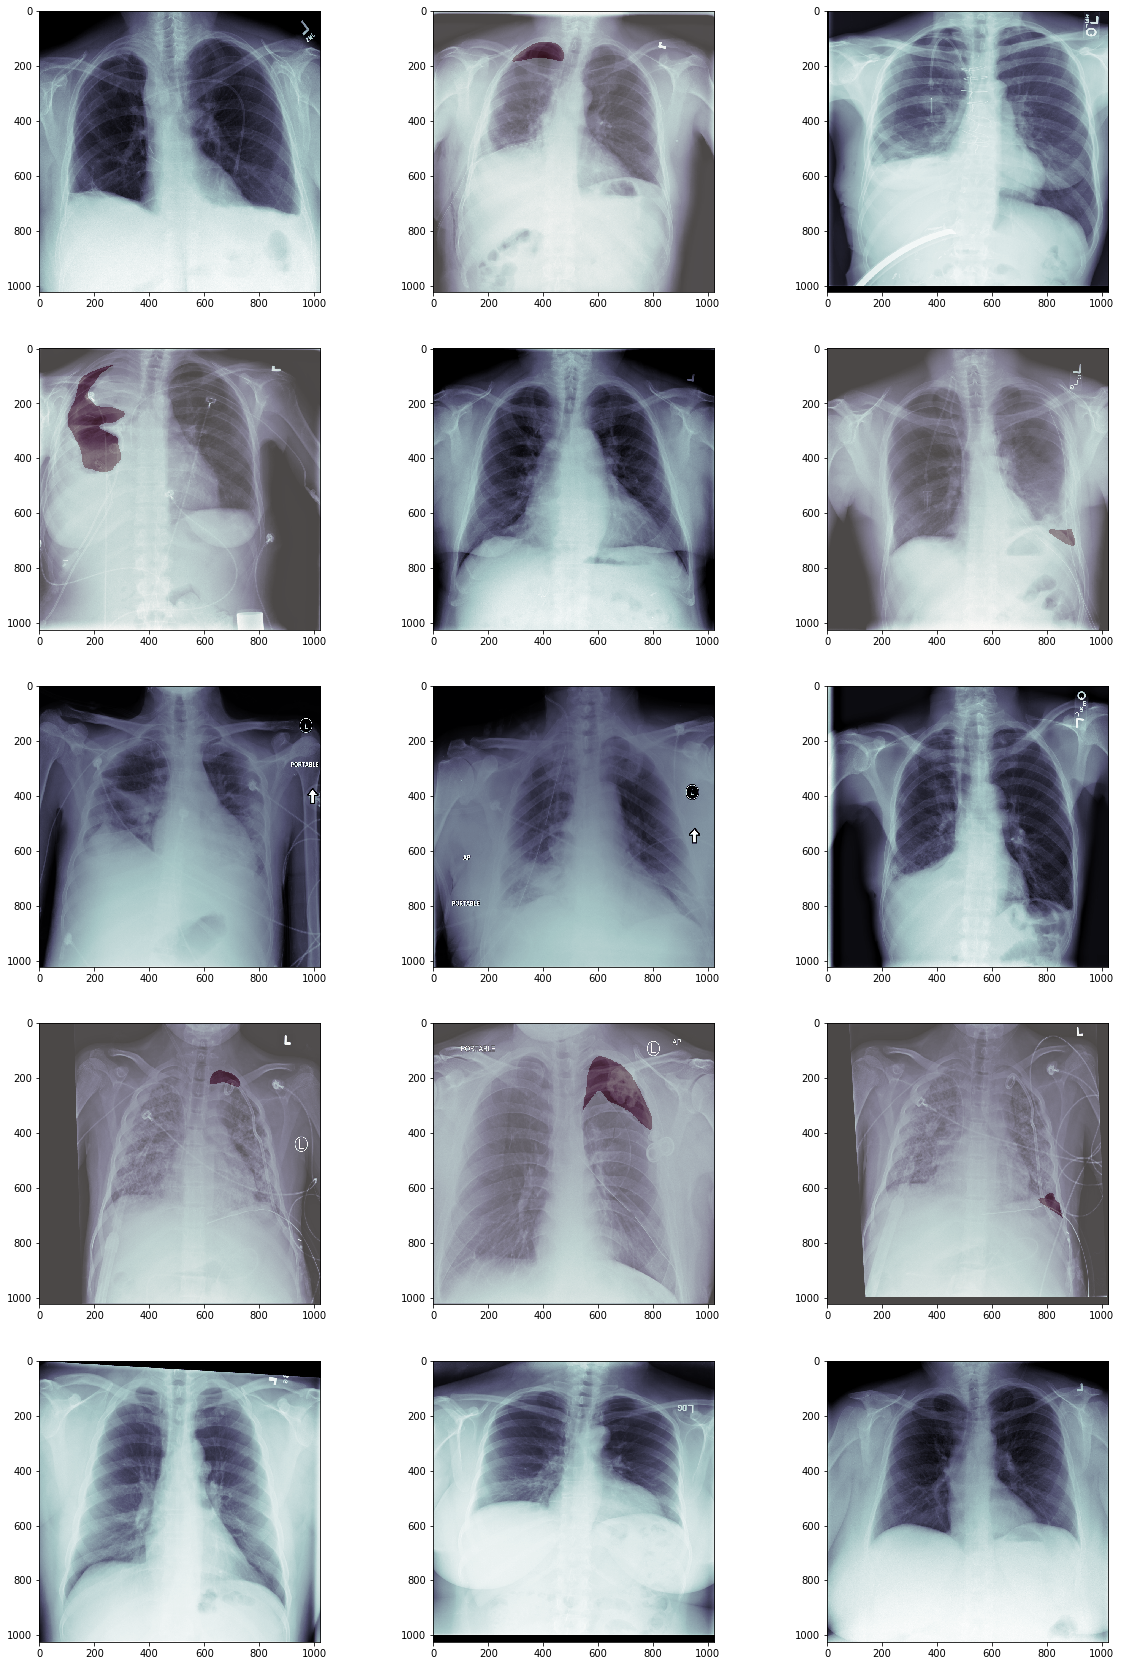

In [56]:
samples = train_df.sample(5 * 3, replace=False)
fig, axs = plt.subplots(5, 3, figsize=(20, 30))
axs = axs.ravel()
for i in range(5 * 3):
    im, meta = read_dicom(samples.iloc[i].Path)
    axs[i].imshow(im, cmap=plt.cm.bone)
    
    rle = samples.iloc[i].EncodedPixels
    if not rle.endswith('-1'):
        mask = rle2mask(rle, meta['height'], meta['width']).T
        axs[i].imshow(mask, alpha=0.3, cmap="Reds")
plt.show()

In [57]:
FIXED_TRAINSET = '/media/hdd/Kaggle/Pneumothorax/Data/trainset.csv'
train_df.to_csv(FIXED_TRAINSET, index=True)

## Test set

In [2]:
TEST_ROOT = '/media/nvme/Datasets/Pneumothorax/dicom-images-test/'

In [3]:
test_paths = []
test_ids = []
for file in glob.glob(TEST_ROOT + '*/*/*.dcm'):
    test_ids.append(file.rstrip('.dcm').split('/')[-1])
    test_paths.append(file)
print(len(test_ids))

1377


In [13]:
test_df = pd.DataFrame(dict(ImageId=test_ids, Path=test_paths)).set_index('ImageId')

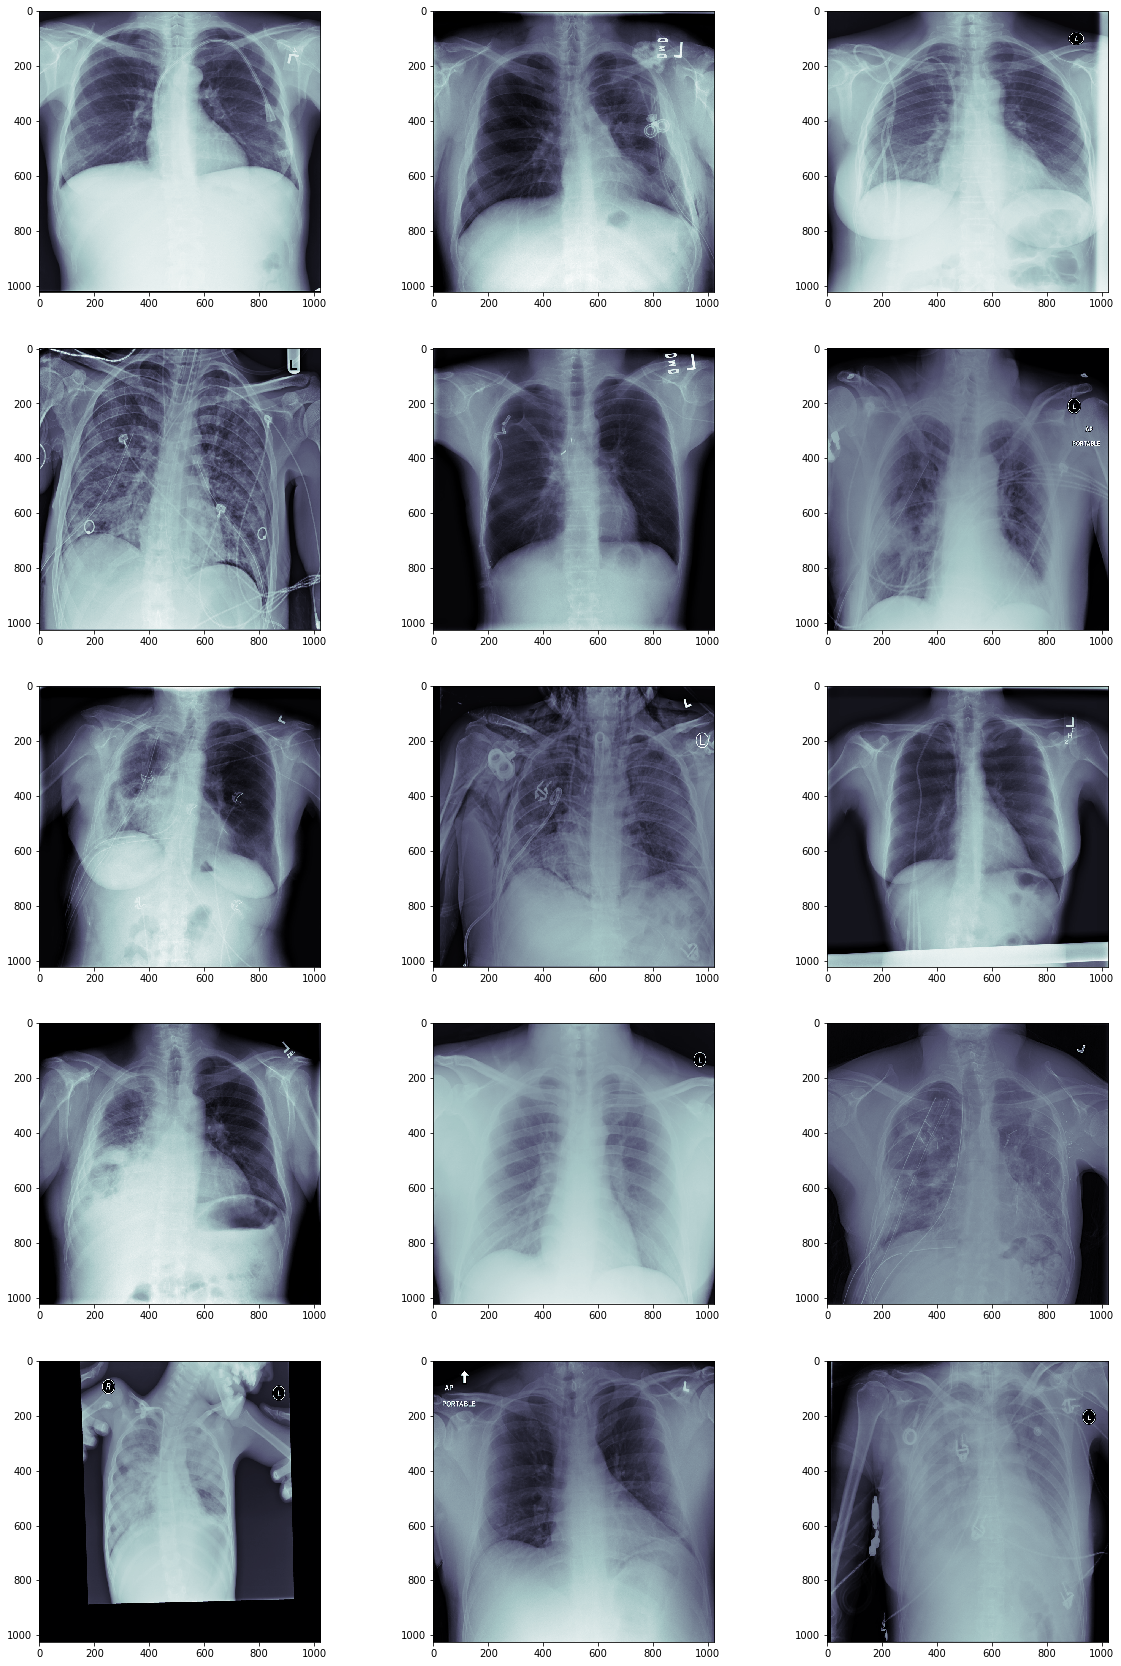

In [63]:
samples = test_df.sample(5 * 3, replace=False)
fig, axs = plt.subplots(5, 3, figsize=(20, 30))
axs = axs.ravel()
for i in range(5 * 3):
    im, meta = read_dicom(samples.iloc[i].Path)
    axs[i].imshow(im, cmap=plt.cm.bone)
plt.show()

In [64]:
FIXED_TESTSET = '/media/hdd/Kaggle/Pneumothorax/Data/testset.csv'
test_df.to_csv(FIXED_TESTSET, index=True)